# [Module 1.2] Personalize Data File 준비

이 노트북은 아래와 같은 작업을 합니다.
---
이 노트북을 모두 실행하는데 걸리는 시간은 약 3분 소요 됩니다.



# 0. 환경 설정

#### Library Import 

파이썬에는 광범위한 라이브러리 모음이 포함되어 있으며, 본 LAB을 위해서 핵심 Data Scientist용 Tool 인 boto3 (AWS SDK) 및 Pandas/Numpy와 같은 라이브러리를 가져와야 합니다. 

In [1]:
import boto3
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt

## Personalize에서 학습 수행을 위한 데이터 제한 오건

Personalize에서 학습을 수행하기 위해서는 다음과 [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html)같은 데이터 요구사항을 맞추어야 합니다. 

* 최소 25명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 2개 이상의 Interaction(예. 구매,평가 등) 기록


하지만 일반적으로 다음과 같은 데이터가 준비 되어 있는것이 좋습니다. 

* 최소 50명 고유 사용자 
* 최소 100개 고유 아이템 
* 사용자 당 24 이상의 Interaction(예. 구매,평가 등) 기록

#### 중요 하이퍼 파라미터
**min_user_history_length_percentile, max_user_history_length_percentile**
- 일반적으로 가지고 있는 interaction의 데이타 셋이 사용자당 interaction의 수가 다릅니다.
즉 1개인 사용자도 많고, 엄청 많은 사용자도 있습니다. **이런 양 극단의 사용자를 제외하고 학습 데이타로 사용하는 것이 더욱 의미있는 추천을 받을 수 있습니다.** 아래 예 및 링크를 참고하시기 바랍니다.
    - For example, setting min_user_history_length_percentile to 0.05 and max_user_history_length_percentile to 0.95 includes all users except those with history lengths at the bottom or top 5%.


- User-Personalization Recipe
    - https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-new-item-USER_PERSONALIZATION.html

# 1. 간단한 데이타 탐색

In [2]:
items = pd.read_csv('../data/items.csv')
items.head(3)

,id,url,sk,name,category,style,description,aliases,price,image,gender_affinity,current_stock,featured
0,e1669081-8ffc-4dec-97a6-e9176d7f6651,http://d32da96qlo1y4g.cloudfront.net/#/product...,NaN,Sans Pareil Scarf,apparel,scarf,Sans pareil scarf for women,NaN,124.99,http://d32da96qlo1y4g.cloudfront.net/images/ap...,F,12,NaN
1,cfafd627-7d6b-43a5-be05-4c7937be417d,http://d32da96qlo1y4g.cloudfront.net/#/product...,NaN,Chef Knife,housewares,kitchen,A must-have for your kitchen,NaN,57.99,http://d32da96qlo1y4g.cloudfront.net/images/ho...,NaN,9,NaN
2,6e6ad102-7510-4a02-b8ce-5a0cd6f431d1,http://d32da96qlo1y4g.cloudfront.net/#/product...,NaN,Gainsboro Jacket,apparel,jacket,This gainsboro jacket for women is perfect for...,NaN,133.99,http://d32da96qlo1y4g.cloudfront.net/images/ap...,F,13,NaN


In [3]:
users = pd.read_csv('../data/users.csv')
users.head(3)

,id,username,email,first_name,last_name,addresses,age,gender,persona,discount_persona,selectable_user
0,1,user1,mark.johnson@example.com,Mark,Johnson,"[{'first_name': 'Mark', 'last_name': 'Johnson'...",31,M,furniture_homedecor_housewares,lower_priced_products,True
1,2,user2,kristen.calderon@example.com,Kristen,Calderon,"[{'first_name': 'Kristen', 'last_name': 'Calde...",58,F,tools_housewares_apparel,discount_indifferent,True
2,3,user3,joseph.maddox@example.com,Joseph,Maddox,"[{'first_name': 'Joseph', 'last_name': 'Maddox...",43,M,floral_beauty_jewelry,lower_priced_products,True


In [4]:
its = pd.read_csv('../data/interactions.csv')
its.head(3)

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP,DISCOUNT
0,26bb732f-9159-432f-91ef-bad14fedd298,3156,ProductViewed,1591803788,No
1,26bb732f-9159-432f-91ef-bad14fedd298,3156,ProductViewed,1591803788,No
2,dc073623-4b95-47d9-93cb-0171c20baa04,332,ProductViewed,1591803812,Yes


데이터를 한번 확인해 봅니다.

### 전체 Interaction 분포

Interaction 분포는 아래와 같습니다. <br>
**유저에 대해서 최소는 20번이고, 중간값은 96번, 최대는 2314번을 rating을 했습니다.**

In [5]:
pd.options.display.max_rows = 10
user_activity_counts = its.groupby("USER_ID").count().loc[:,["EVENT_TYPE"]].rename(columns={"EVENT_TYPE":"INTERACTION_COUNTS"})
user_activity_counts.describe()

,INTERACTION_COUNTS
count,5250.000000
mean,128.572190
std,33.408015
min,43.000000
25%,104.000000
50%,127.000000
75%,152.000000
max,260.000000


### 인터렉션 숫자당 유저 수



In [6]:
user_interaction_counts=user_activity_counts.reset_index()
activities = user_interaction_counts.groupby('INTERACTION_COUNTS').count()
activities.columns=['NUM_USERS']
activities

,NUM_USERS
INTERACTION_COUNTS,
43,1
45,2
49,1
50,1
51,2
...,...
229,1
231,2
235,1


전체 인터렉션 횟수 분포를 확인 합니다.

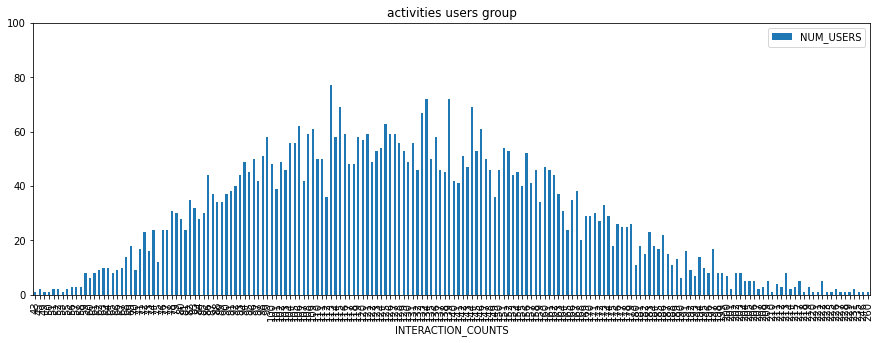

In [7]:
num_interactions = 260
activities.loc[:num_interactions,:].plot(kind='bar', figsize=(15,5), ylim=(0,100))
plt.title("activities users group")

plt.show()

일부 분포 (예: 100 번)  까지의 분포를 확인 합이다.

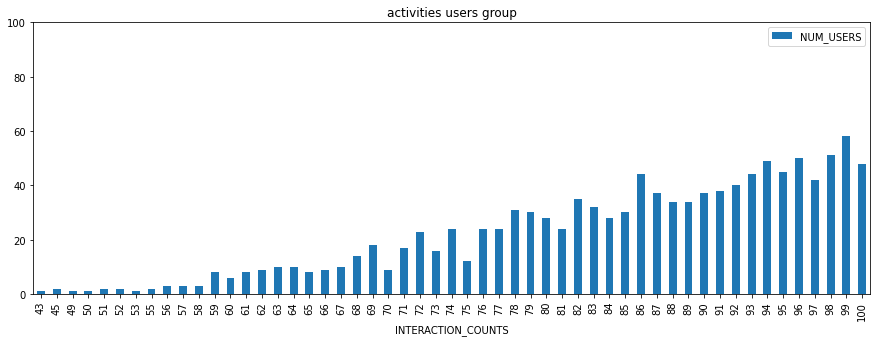

In [8]:
num_interactions = 100
activities.loc[:num_interactions,:].plot(kind='bar', figsize=(15,5), ylim=(0,100))
plt.title("activities users group")

plt.show()

# 2. 데이터 필드 선택 및 변형

아래와 같은 순서로 데이터 필드를 선택하고 준비를 합니다.
- 필수적인 데이타를 중심으로 선택
- 퍼스널라이즈에서 요구하는 컬럼 이름으로 수정
- 선택된 데이터 필드의 타입을 적당하게 변경

### 참고
- ECOMMERCE datasets and schemas
    - https://docs.aws.amazon.com/personalize/latest/dg/ECOMMERCE-datasets-and-schemas.html

## Items

In [9]:
items.columns

Index(['id', 'url', 'sk', 'name', 'category', 'style', 'description',
       'aliases', 'price', 'image', 'gender_affinity', 'current_stock',
       'featured'],
      dtype='object')

In [10]:
def item_data_selection(df, cols):
    ldf = df[cols]
    ldf = ldf.rename(columns={'id':'ITEM_ID',
                              'name' : 'NAME',
                              'category' :'CATEGORY_L1',
                              'style' : 'STYLE',
                              'description' : 'PRODUCT_DESCRIPTION',
                              'price' : 'PRICE',
                              
                             })
    
    return ldf


item_cols = ['id', 'name', 'category', 'style', 'description','price']


items_df = item_data_selection(items, item_cols)    


items_df.head()

,ITEM_ID,NAME,CATEGORY_L1,STYLE,PRODUCT_DESCRIPTION,PRICE
0,e1669081-8ffc-4dec-97a6-e9176d7f6651,Sans Pareil Scarf,apparel,scarf,Sans pareil scarf for women,124.99
1,cfafd627-7d6b-43a5-be05-4c7937be417d,Chef Knife,housewares,kitchen,A must-have for your kitchen,57.99
2,6e6ad102-7510-4a02-b8ce-5a0cd6f431d1,Gainsboro Jacket,apparel,jacket,This gainsboro jacket for women is perfect for...,133.99
3,49b89871-5fe7-4898-b99d-953e15fb42b2,High Definition Speakers,electronics,speaker,High definition speakers to fill the house wit...,196.99
4,5cb18925-3a3c-4867-8f1c-46efd7eba067,Spiffy Sandals,footwear,sandals,This spiffy pair of sandals for woman is perfe...,9.99


## Users

In [11]:
users.columns

Index(['id', 'username', 'email', 'first_name', 'last_name', 'addresses',
       'age', 'gender', 'persona', 'discount_persona', 'selectable_user'],
      dtype='object')

In [12]:
def user_data_selection(df, cols):
    ldf = df[cols]
    ldf = ldf.rename(columns={'id':'USER_ID',
                              'username' : 'USER_NAME',
                              'age' :'AGE',
                              'gender' : 'GENDER',                              
                             })
    
    return ldf

user_cols = ['id', 'username', 'age', 'gender']


users_df = user_data_selection(users, user_cols)    
users_df.head()
    

,USER_ID,USER_NAME,AGE,GENDER
0,1,user1,31,M
1,2,user2,58,F
2,3,user3,43,M
3,4,user4,38,M
4,5,user5,24,M


### Users 데이터 타입 변경

In [13]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   USER_ID    5250 non-null   int64 
 1   USER_NAME  5250 non-null   object
 2   AGE        5250 non-null   int64 
 3   GENDER     5250 non-null   object
dtypes: int64(2), object(2)
memory usage: 164.2+ KB


In [14]:
def change_data_type(df, col, target_type):
    ldf = df.copy()
    ldf[col] = ldf[col].astype(target_type)
    
    return ldf
    

In [15]:
users_df = change_data_type(users_df, col='USER_ID', target_type='object')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   USER_ID    5250 non-null   object
 1   USER_NAME  5250 non-null   object
 2   AGE        5250 non-null   int64 
 3   GENDER     5250 non-null   object
dtypes: int64(1), object(3)
memory usage: 164.2+ KB


## Interactions

In [16]:
its.columns

Index(['ITEM_ID', 'USER_ID', 'EVENT_TYPE', 'TIMESTAMP', 'DISCOUNT'], dtype='object')

In [17]:
def interactions_data_selection(df, cols):
    ldf = df[cols]
    ldf = ldf.rename(columns={'id':'USER_ID',
                              'username' : 'USER_NAME',
                              'age' :'AGE',
                              'gender' : 'GENDER',                              
                             })
    
    return ldf

interactions_cols = ['ITEM_ID', 'USER_ID', 'EVENT_TYPE', 'TIMESTAMP']


full_interactions_df = interactions_data_selection(its, interactions_cols)    
full_interactions_df.head()
    

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP
0,26bb732f-9159-432f-91ef-bad14fedd298,3156,ProductViewed,1591803788
1,26bb732f-9159-432f-91ef-bad14fedd298,3156,ProductViewed,1591803788
2,dc073623-4b95-47d9-93cb-0171c20baa04,332,ProductViewed,1591803812
3,dc073623-4b95-47d9-93cb-0171c20baa04,332,ProductViewed,1591803812
4,31efcfea-47d6-43f3-97f7-2704a5397e22,3981,ProductViewed,1591803830


## 인터렉션의 EVENT_TYPE 의 두가지 선택

- 우리는 여기서 "ProductViewed" , "OrderCompleted" 를 선택하고 각각 이름을 "View" , "Purchase" 로 바꿉니다.

In [18]:
full_interactions_df.EVENT_TYPE.value_counts()

ProductViewed      581900
ProductAdded        46552
CartViewed          29095
CheckoutStarted     11638
OrderCompleted       5819
Name: EVENT_TYPE, dtype: int64

In [19]:
def filter_interactions_data(df, kinds_event_type):
    ldf = df[df['EVENT_TYPE'].isin(kinds_event_type)]
    ldf['EVENT_TYPE'] = ldf['EVENT_TYPE'].replace(['ProductViewed'],'View')    
    ldf['EVENT_TYPE'] = ldf['EVENT_TYPE'].replace(['OrderCompleted'],'Purchase')        
    
    return ldf

select_event_types = ['ProductViewed','OrderCompleted']
interactions_df = filter_interactions_data(full_interactions_df, select_event_types)
interactions_df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP
0,26bb732f-9159-432f-91ef-bad14fedd298,3156,View,1591803788
1,26bb732f-9159-432f-91ef-bad14fedd298,3156,View,1591803788
2,dc073623-4b95-47d9-93cb-0171c20baa04,332,View,1591803812
3,dc073623-4b95-47d9-93cb-0171c20baa04,332,View,1591803812
4,31efcfea-47d6-43f3-97f7-2704a5397e22,3981,View,1591803830
...,...,...,...,...
674996,94a0ad41-8b19-4ecb-b0d7-33704e2d4421,4046,View,1598204625
674997,f9c470b0-152b-4776-893a-67ffc4064675,2627,View,1598204657
674998,1def0093-96b2-4cc4-a022-071941f75b92,3538,View,1598204664
674999,9bc87696-e9bd-4241-86b0-234e054a607b,5165,View,1598204678


### 인터렉션 데이터 타입 변경

In [20]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587719 entries, 0 to 675003
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ITEM_ID     587719 non-null  object
 1   USER_ID     587719 non-null  int64 
 2   EVENT_TYPE  587719 non-null  object
 3   TIMESTAMP   587719 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 22.4+ MB


In [21]:
interactions_df = change_data_type(interactions_df, col='USER_ID', target_type='object')
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587719 entries, 0 to 675003
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ITEM_ID     587719 non-null  object
 1   USER_ID     587719 non-null  object
 2   EVENT_TYPE  587719 non-null  object
 3   TIMESTAMP   587719 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 22.4+ MB


# 3. 데이터 분리

이 데이터에는 UserID, ItemID, Event_Type 및 Timestamp 컬럼이 포함되어 있습니다.<br>

- 시간순으로 정렬한 후에 90%는 학습용 데이터로, 마지막 최근 10% 데이터를 검증용 데이터로 분리합니다.



## Data Set을 Train, Validation(holdout) 데이터 분리하기 

모든 사용자의 마지막(Timestamp기준으로) 10%의 데이터를 Validation(Holdout) 데이터로 분리합니다.

In [22]:
pd.options.display.max_rows = 5
def split_holdout(data, pct):
    df = data.copy()
    # Rank per each subgroup, 'USER_ID'
    ranks = df.groupby('USER_ID').TIMESTAMP.rank(pct=True, method='first')
    df = df.join((ranks> pct).to_frame('holdout'))
    
    holdout = df[df['holdout']].drop('holdout', axis=1)
    train = df[~df['holdout']].drop('holdout', axis=1)    
    
    return train, holdout

df_warm_train, df_warm_holdout = split_holdout(interactions_df, pct=0.9)

train 과 holdout의 분리된 데이타의 정보입니다. holdout은 대략 전체 대비 10%의 Row의 갯수 입니다. holdout의 timestamp는 train보다 미래의 숫자인 것을 인지할 수 있습니다. (숫자가 많은 것이 더 미래의 날짜를 의미함)

In [23]:
df_warm_train.info()
df_warm_train.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526581 entries, 0 to 664340
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ITEM_ID     526581 non-null  object
 1   USER_ID     526581 non-null  object
 2   EVENT_TYPE  526581 non-null  object
 3   TIMESTAMP   526581 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 20.1+ MB


ITEM_ID         2449
USER_ID         5250
EVENT_TYPE         2
TIMESTAMP     282956
dtype: int64

In [24]:
df_warm_holdout.info()
df_warm_holdout.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61138 entries, 432222 to 675003
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ITEM_ID     61138 non-null  object
 1   USER_ID     61138 non-null  object
 2   EVENT_TYPE  61138 non-null  object
 3   TIMESTAMP   61138 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


ITEM_ID        2446
USER_ID        5250
EVENT_TYPE        2
TIMESTAMP     34393
dtype: int64

In [25]:
df_warm_train.sort_values(['USER_ID','TIMESTAMP'])

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP
21464,35efa417-357d-465e-99cb-b208bbc63f8b,1,View,1592007327
21465,35efa417-357d-465e-99cb-b208bbc63f8b,1,View,1592007327
...,...,...,...,...
585017,072ded32-2903-4f35-9f28-d6284c5f5605,5250,View,1597351374
585018,072ded32-2903-4f35-9f28-d6284c5f5605,5250,View,1597351374


In [26]:
df_warm_holdout.sort_values(['USER_ID','TIMESTAMP'])

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP
612212,be14695b-f8cb-46b8-aecd-ef28f0218514,1,View,1597609245
621508,079ab14b-3435-4a95-ba1d-fc0b21e0cf4b,1,View,1597697421
...,...,...,...,...
609116,e66109bf-9ad5-430a-90e5-900c00119f39,5250,View,1597579890
662349,072ded32-2903-4f35-9f28-d6284c5f5605,5250,View,1598084705


# 4. 로컬에 train, item, validation(holdout) 및 coldstart 를 CSV 저장

완료되면 파일을 새 CSV로 저장한 다음, S3에 업로드합니다.<br>

In [27]:
import os
os.makedirs('dataset', exist_ok=True)

train, item, validation(holdout) 데이터를 로컬에 csv 파일로 저장 합니다.

In [28]:
# train, item, validation 로컬 저장
warm_train_interaction_filename="dataset/training_interaction.csv"
items_filename="dataset/training_item.csv"
users_filename="dataset/training_usedr.csv"
validation_interaction_filename="dataset/validation_interaction.csv"

df_warm_train.to_csv(warm_train_interaction_filename,index=False)
items_df.to_csv(items_filename,index=False)
users_df.to_csv(users_filename,index=False)
df_warm_holdout.to_csv(validation_interaction_filename,index=False)      



In [29]:
# warm data set 로컬 저장
warm_interation_filename="dataset/warm_interaction.csv"
interactions_df.to_csv(warm_interation_filename,index=False)


## S3에 로컬 CSV 업로드

In [30]:
import sagemaker
#bucket='<YOUR BUCKET NAME>' # replace with the name of your S3 bucket
bucket = sagemaker.Session().default_bucket()  

In [31]:
#upload file for training
response_upload = boto3.Session().resource('s3').Bucket(bucket).Object(warm_train_interaction_filename).upload_file(warm_train_interaction_filename)
boto3.Session().resource('s3').Bucket(bucket).Object(users_filename).upload_file(users_filename)
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

s3_warm_train_interaction_filename = "s3://{}/{}".format(bucket, warm_train_interaction_filename)
s3_items_filename = "s3://{}/{}".format(bucket, items_filename)
s3_users_filename = "s3://{}/{}".format(bucket, users_filename)

print("s3_warm_train_interaction_filename: \n", s3_warm_train_interaction_filename)
print("s3_items_filename: \n", s3_items_filename)
print("s3_users_filename: \n", s3_users_filename)



s3_warm_train_interaction_filename: 
 s3://sagemaker-ap-northeast-2-057716757052/dataset/training_interaction.csv
s3_items_filename: 
 s3://sagemaker-ap-northeast-2-057716757052/dataset/training_item.csv
s3_users_filename: 
 s3://sagemaker-ap-northeast-2-057716757052/dataset/training_usedr.csv


In [32]:
! aws s3 ls {s3_warm_train_interaction_filename} --recursive
! aws s3 ls {s3_items_filename} --recursive
! aws s3 ls {s3_users_filename} --recursive

2022-01-02 12:21:58   30451496 dataset/training_interaction.csv
2022-01-02 12:22:00     300071 dataset/training_item.csv
2022-01-02 12:21:59      97565 dataset/training_usedr.csv


In [33]:
%store bucket
%store s3_warm_train_interaction_filename
%store s3_users_filename
%store s3_items_filename
%store warm_train_interaction_filename
%store items_filename
%store users_filename
%store validation_interaction_filename

%store warm_interation_filename


Stored 'bucket' (str)
Stored 's3_warm_train_interaction_filename' (str)
Stored 's3_users_filename' (str)
Stored 's3_items_filename' (str)
Stored 'warm_train_interaction_filename' (str)
Stored 'items_filename' (str)
Stored 'users_filename' (str)
Stored 'validation_interaction_filename' (str)
Stored 'warm_interation_filename' (str)
